In [866]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing
import pickle

from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelBinarizer

from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, auc, roc_curve, RocCurveDisplay, confusion_matrix, classification_report
from sklearn.multiclass import OneVsRestClassifier
from itertools import cycle

DATASET_COLUMNS = ['Id', 'Review', 'Sentiment']
senti_labels = {1: 'Negative', 2: 'Neutral', 3: 'Positive'}
senti_categories = list(senti_labels.values())
NUM_of_CLASSES = 3

input_folder_path = "./pls/Thesis_Jupyter_Final/input/"
processed_folder_path = "./pls/Thesis_Jupyter_Final/processed"
data_filename = "reviews_data.csv"
cleaned_data_filename = "cleaned_data.csv"
vocab_filename = 'vocab.txt'

In [867]:
train = pd.read_csv(os.path.join(input_folder_path, "train.csv"))
val = pd.read_csv(os.path.join(input_folder_path, "val.csv"))
test = pd.read_csv(os.path.join(input_folder_path, "test.csv"))

x_train = pd.read_csv(os.path.join(processed_folder_path, "train_tfidf.csv"))
y_train = train['y']
x_val = pd.read_csv(os.path.join(processed_folder_path, "val_tfidf.csv"))
y_val = val['y']
x_test = pd.read_csv(os.path.join(processed_folder_path, "test_tfidf.csv"))
y_test = test['y']

## Evaluation Functions

In [ ]:
def one_hot_encode(y):
    y_encoded = np.zeros((len(y), NUM_of_CLASSES))
    for i, label in enumerate(y):
        y_encoded[i, label - 1] = 1

    return y_encoded

In [ ]:
def calculate_metrics(y, y_pred):
    accuracy = accuracy_score(y, y_pred)
    # TODO: not anymore?? Handle the zero-division error when there are no predicted samples for a label
    # only interested in labels that were predicted at least once
    precision = precision_score(y, y_pred, average='weighted', labels=np.unique(y_pred))
    recall = recall_score(y, y_pred, average='weighted')
    f1 = f1_score(y, y_pred, average='weighted', labels=np.unique(y_pred))
    
    print(f"Accuracy: {(accuracy * 100):.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"f1-score: {f1:.2f}")

In [ ]:
def calculate_classification_report(y, y_pred, labels):
    report = classification_report(y, y_pred, labels=labels)
    print("Classification Report:\n", report)

In [ ]:
def plot_confusion_matrix(y_true, y_pred, labels):
    cnf_mat = confusion_matrix(y_true, y_pred)
    mat_disp = ConfusionMatrixDisplay(confusion_matrix=cnf_mat, display_labels=labels)
    mat_disp = mat_disp.plot(cmap='Blues', xticks_rotation='vertical')
    plt.title(f'Confusion Matrix')
    plt.show()

In [ ]:
# TODO: can I use for svm?
def plot_feature_imp(model):
    importances = model.feature_importances_
    feature_names = tfidf_vectorizer.get_feature_names_out()
    feature_importances = pd.Series(importances, index=feature_names)

    fig, ax = plt.subplots()
    feature_importances.nlargest(20).plot.bar(ax=ax)
    ax.set_title("Top 20 Most Predictive Features")
    ax.set_xlabel('Feature')
    ax.set_ylabel('Importance')
    fig.tight_layout()

In [ ]:
def evaluate_model(model, model_name, x, y, params, only_metrics):    
    y_pred = model.predict(x)

    print(f"*{model_name}")

    calculate_metrics(y, y_pred)
    print(f"Params: {params}\n")
    
    senti_labels = ['negative', 'neutral', 'positive'] #TODO: to constants
    
    if not only_metrics:
        calculate_classification_report(y, y_pred, labels=senti_labels)
        plot_confusion_matrix(y, y_pred, labels=senti_labels)
        plot_feature_imp(model) #TODO: for especially RF

In [ ]:
def plot_roc_curve(prob_test_vec, y_test, labels):
    fig, ax = plt.subplots(figsize=(10, 10))
    labels = labels
    colors = cycle(['limegreen', 'dodgerblue', 'red'])
    for senti, color in zip(range(NUM_of_CLASSES), colors):
        RocCurveDisplay.from_predictions(
            y_test[:, senti],
            prob_test_vec[:, senti],
            name=f"ROC curve for {labels[senti]}",
            color=color,
            ax=ax,
        )

In [ ]:
def calculate_OvR_roc_auc_score(model, x, y, x_test, y_test, labels): #average??
    y = one_hot_encode(y)
    y_test = one_hot_encode(y_test)

    ovr_model = OneVsRestClassifier(model).fit(x, y)
    prob_test_vec = ovr_model.predict_proba(x_test)
    
    fpr, tpr, thresholds, auc_score = [], [], [], []
    for _ in range(NUM_of_CLASSES):
        fpr.append(0)
        tpr.append(0)
        thresholds.append(0)
        auc_score.append(0)
    
    for i in range(NUM_of_CLASSES):
        fpr[i], tpr[i], thresholds[i] = roc_curve(y_test[:, i], prob_test_vec[:, i])
        auc_score[i] = auc(fpr[i], tpr[i])

    print(f"AUC score: {auc_score}")
    averaged_auc_score = (sum(auc_score) / NUM_of_CLASSES)
    print(f"Averaged AUC score: {averaged_auc_score:.2f}")
    
    plot_roc_curve(prob_test_vec, y_test, labels)

In [ ]:
def print_top3_models(top3_models):    
    # Print the sorted list of mean test scores and standard deviation of test scores
    print("\nTop 3 parameter combinations ranked by performance (from best to worst):")
    for index, row in top3_models.iterrows():
        mean_score = row['mean_test_score']
        std_score = row['std_test_score']
        params = row['params']
        print(f"Mean Test Score: {mean_score:.4f} (±{std_score:.4f}) for {params}")

## 1. Random Forest

### Training & Tuning

In [ ]:
# Create instances of the Random Forest model
rf_classifier = RandomForestClassifier()

In [ ]:
# Define the parameter grid for grid search
rf_param_grid = {
    'n_estimators': [20, 50, 100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10, 30, 50],
    'min_samples_leaf': [1, 5, 20, 50],  # Minimum number of samples required to be at a leaf node
    #'max_features': ['auto', 'sqrt'],  # Number of features to consider when looking for the best split
}

In [ ]:
# Perform grid search
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=rf_param_grid, cv=5)
grid_search.fit(x_train, y_train)

# Get the mean test scores and standard deviations of test scores for all parameter combinations
results_df = pd.DataFrame(grid_search.cv_results_)
sorted_results = results_df.sort_values(by=['mean_test_score', 'std_test_score'], ascending=[False, True])
top3_models = sorted_results[:3]
print_top3_models(top3_models)

### Evaluation

#### Validation Set

In [ ]:
top3_params = top3_models['params'].values
res_filename = "rf_results"

# Evaluate the top 3 models on the validation set
rf_cand_0 = RandomForestClassifier(**top3_params[0])
rf_cand_0.fit(x_train, y_train)
evaluate_model(rf_cand_0, "Training-RF-0", x_train, y_train, top3_params[0], only_metrics=True)
evaluate_model(rf_cand_0, "Validation-RF-0", x_val, y_val, top3_params[0], only_metrics=True)

rf_cand_1 = RandomForestClassifier(**top3_params[1])
rf_cand_1.fit(x_train, y_train)
evaluate_model(rf_cand_1, "Training-RF-1", x_train, y_train, top3_params[1], only_metrics=True)
evaluate_model(rf_cand_1, "Validation-RF-1", x_val, y_val, top3_params[1], only_metrics=True)

rf_cand_2 = RandomForestClassifier(**top3_params[2])
rf_cand_2.fit(x_train, y_train)
evaluate_model(rf_cand_2, "Training-RF-2", x_train, y_train, top3_params[2], only_metrics=True)
evaluate_model(rf_cand_2, "Validation-RF-2", x_val, y_val, top3_params[2], only_metrics=True)

*Training-RF-0
Accuracy: 98.50
Precision: 0.99
Recall: 0.98
f1-score: 0.98
Params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}

*Validation-RF-0
Accuracy: 89.69
Precision: 0.85
Recall: 0.90
f1-score: 0.86
Params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}

*Training-RF-1
Accuracy: 96.73
Precision: 0.97
Recall: 0.97
f1-score: 0.96
Params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}

*Validation-RF-1
Accuracy: 89.62
Precision: 0.85
Recall: 0.90
f1-score: 0.86
Params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}

*Training-RF-2
Accuracy: 98.61
Precision: 0.99
Recall: 0.99
f1-score: 0.99
Params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}

*Validation-RF-2
Accuracy: 89.88
Precision: 0.85
Recall: 0.90
f1-score: 0.86
Params: {'max_depth': None, 'min_samples_leaf': 1, 'min_s

#### Test Set

*RF-best
Accuracy: 89.44
Precision: 0.86
Recall: 0.89
f1-score: 0.86
Params: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 300, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}

Classification Report:
               precision    recall  f1-score   support

           1       0.60      0.15      0.24       120
           2       0.43      0.03      0.06        98
           3       0.90      0.99      0.94      1781

    accuracy                           0.89      1999
   macro avg       0.64      0.39      0.41      1999
weighted avg       0.86      0.89      0.86      1999



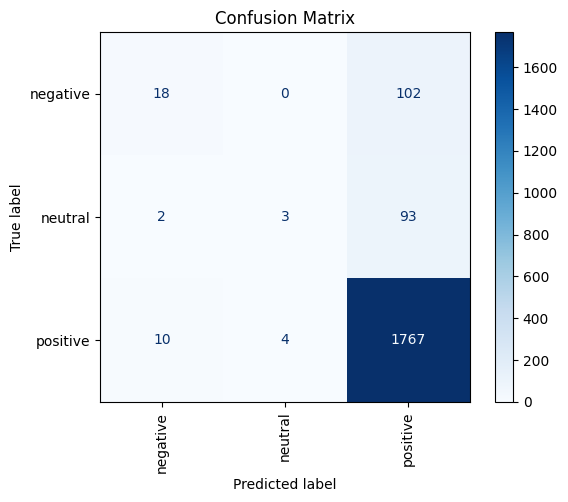

AUC score: [0.8655690083377684, 0.7759503591020839, 0.8677915200717049]
Averaged AUC score: 0.84


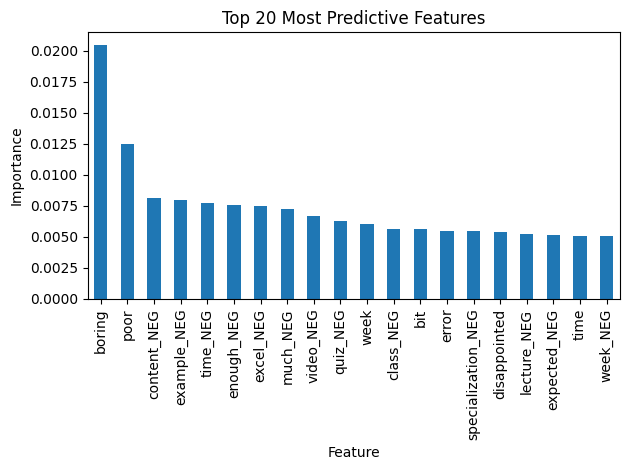

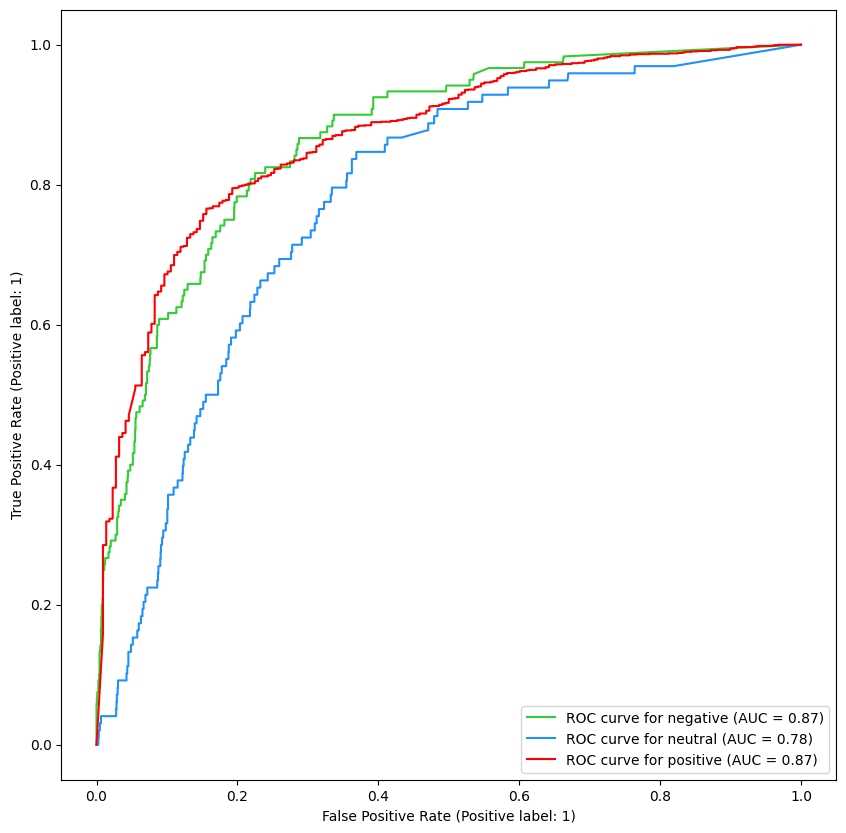

In [ ]:
# Set the best model and evaluate the models on the test data #TODO
rf_best = rf_cand_0
y_pred = rf_best.predict(x_test)
evaluate_model(rf_best, "RF-best", x_test, y_test, rf_best.get_params(), only_metrics=False)
# Calculate OvR AUC ROC score
senti_labels = ['negative', 'neutral', 'positive'] # TODO
calculate_OvR_roc_auc_score(rf_best, x_train, y_train, x_test, y_test, senti_labels)

## 2. Naive Bayes

### Training & Tuning

In [ ]:
# Create instances of the Naive Bayes model & fit on training data
nb_model = MultinomialNB()

In [ ]:
# Fit the model to the training data
nb_model.fit(x_train, y_train)

# Predict on the training data
y_train_pred = nb_model.predict(x_train)

# Calculate the training accuracy score
accuracy = accuracy_score(y_train, y_train_pred)
print("Training Accuracy:", accuracy)
print(nb_model.get_params())

Training Accuracy: 0.8963414634146342
{'alpha': 1.0, 'class_prior': None, 'fit_prior': True, 'force_alpha': 'warn'}


In [ ]:
# Define the parameter grid for grid search
nb_param_grid = {
    'alpha': [0.1, 0.5, 1.0],  # Smoothing parameter for MultinomialNB
    'fit_prior': [True, False]
}

In [ ]:
# Perform grid search
grid_search = GridSearchCV(estimator=nb_model, param_grid=nb_param_grid, cv=5)
grid_search.fit(x_train, y_train)

# Get the mean test scores and standard deviations of test scores for all parameter combinations
results_df = pd.DataFrame(grid_search.cv_results_)
sorted_results = results_df.sort_values(by=['mean_test_score', 'std_test_score'], ascending=[False, True])
top3_models = sorted_results[:3]
print_top3_models(top3_models)


Top 3 parameter combinations ranked by performance (from best to worst):
Mean Test Score: 0.8868 (±0.0047) for {'alpha': 1.0, 'fit_prior': True}
Mean Test Score: 0.8849 (±0.0082) for {'alpha': 0.1, 'fit_prior': True}
Mean Test Score: 0.8840 (±0.0071) for {'alpha': 0.5, 'fit_prior': True}


### Evaluation

#### Validation Set

In [ ]:
top3_params = top3_models['params'].values

# Evaluate the top 3 models on the validation set
nb_cand_0 = MultinomialNB(**top3_params[0])
nb_cand_0.fit(x_train, y_train)
evaluate_model(nb_cand_0, "Training-NB-0", x_train, y_train, top3_params[0], only_metrics=True)
evaluate_model(nb_cand_0, "Validation-NB-0", x_val, y_val, top3_params[0], only_metrics=True)

nb_cand_1 = MultinomialNB(**top3_params[1])
nb_cand_1.fit(x_train, y_train)
evaluate_model(nb_cand_1, "Training-NB-1", x_train, y_train, top3_params[1], only_metrics=True)
evaluate_model(nb_cand_1, "Validation-NB-1", x_val, y_val, top3_params[1], only_metrics=True)

nb_cand_2 = MultinomialNB(**top3_params[2])
nb_cand_2.fit(x_train, y_train)
evaluate_model(nb_cand_2, "Training-NB-2", x_train, y_train, top3_params[2], only_metrics=True)
evaluate_model(nb_cand_2, "Validation-NB-2", x_val, y_val, top3_params[2], only_metrics=True)

*Training-NB-0
Accuracy: 89.63
Precision: 0.89
Recall: 0.90
f1-score: 0.88
Params: {'alpha': 1.0, 'fit_prior': True}

*Validation-NB-0
Accuracy: 89.06
Precision: 0.84
Recall: 0.89
f1-score: 0.87
Params: {'alpha': 1.0, 'fit_prior': True}

*Training-NB-1
Accuracy: 90.46
Precision: 0.90
Recall: 0.90
f1-score: 0.89
Params: {'alpha': 0.1, 'fit_prior': True}

*Validation-NB-1
Accuracy: 89.12
Precision: 0.86
Recall: 0.89
f1-score: 0.87
Params: {'alpha': 0.1, 'fit_prior': True}

*Training-NB-2
Accuracy: 89.73
Precision: 0.89
Recall: 0.90
f1-score: 0.88
Params: {'alpha': 0.5, 'fit_prior': True}

*Validation-NB-2
Accuracy: 89.06
Precision: 0.86
Recall: 0.89
f1-score: 0.87
Params: {'alpha': 0.5, 'fit_prior': True}



#### Test Set

*NB-best
Accuracy: 89.44
Precision: 0.86
Recall: 0.89
f1-score: 0.86
Params: {'alpha': 1.0, 'class_prior': None, 'fit_prior': True, 'force_alpha': 'warn'}

Classification Report:
               precision    recall  f1-score   support

           1       0.60      0.15      0.24       120
           2       0.43      0.03      0.06        98
           3       0.90      0.99      0.94      1781

    accuracy                           0.89      1999
   macro avg       0.64      0.39      0.41      1999
weighted avg       0.86      0.89      0.86      1999



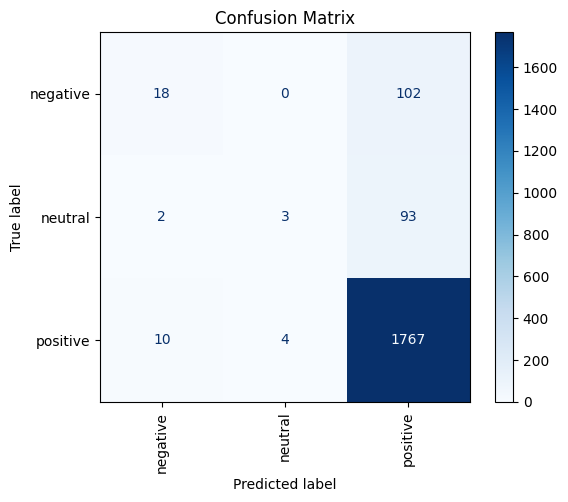

AUC score: [0.89252261841405, 0.7837094332735725, 0.879452580500595]
Averaged AUC score: 0.85


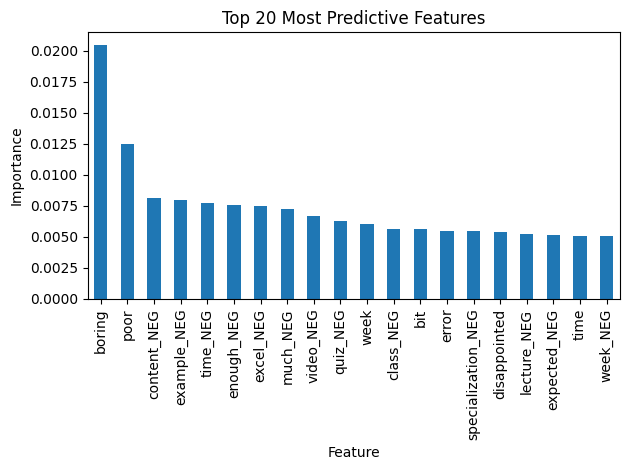

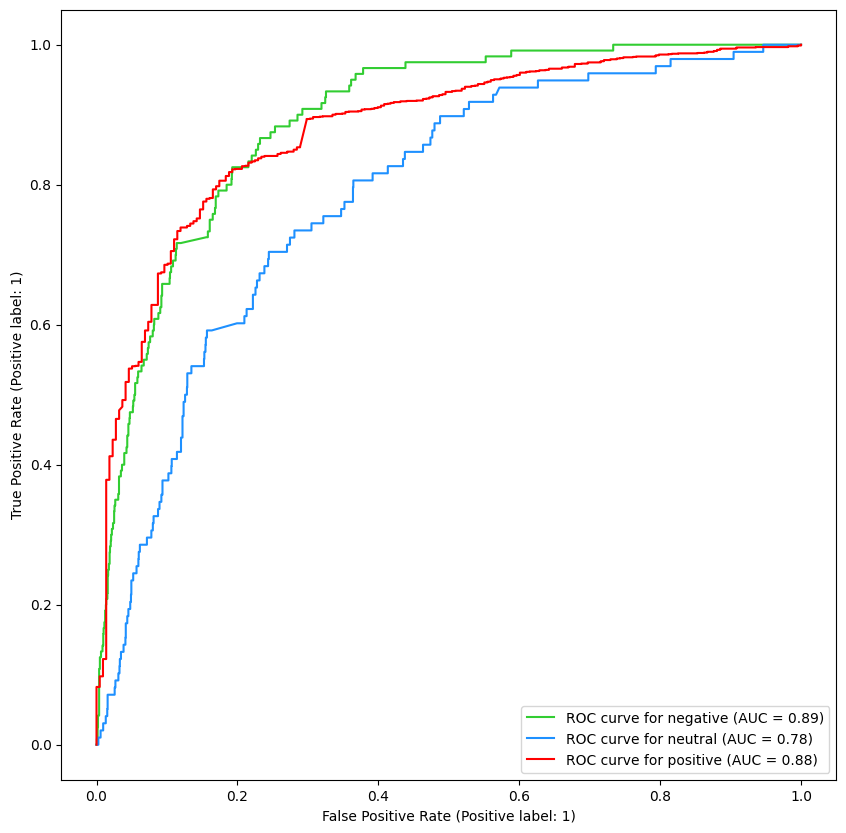

In [ ]:
# Set the best model and evaluate the models on the test data #TODO
nb_best = nb_cand_0
y_pred = nb_best.predict(x_test)
evaluate_model(rf_best, "NB-best", x_test, y_test, nb_best.get_params(), only_metrics=False)
calculate_OvR_roc_auc_score(nb_best, x_train, y_train, x_test, y_test, senti_labels)

## 3. SVM

### Training &  Tuning

In [ ]:
# Create instances of the SVM model
svm_model = SVC()

In [ ]:
# Define the parameter grid for grid search
svm_param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': [0.1, 1, 'scale']
}

In [ ]:
# Perform grid search
grid_search = GridSearchCV(svm_model, param_grid=svm_param_grid, cv=5)
grid_search.fit(x_train, y_train)

# Get the mean test scores and standard deviations of test scores for all parameter combinations
results_df = pd.DataFrame(grid_search.cv_results_)
sorted_results = results_df.sort_values(by=['mean_test_score', 'std_test_score'], ascending=[False, True])
top3_models = sorted_results[:3]
print_top3_models(top3_models)


Top 3 parameter combinations ranked by performance (from best to worst):
Mean Test Score: 0.9013 (±0.0037) for {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Mean Test Score: 0.9013 (±0.0043) for {'C': 10, 'gamma': 1, 'kernel': 'rbf'}
Mean Test Score: 0.9012 (±0.0025) for {'C': 1, 'gamma': 0.1, 'kernel': 'linear'}


### Evaluation

#### Validation set

In [ ]:
top3_params = top3_models['params'].values

# Evaluate the top 3 models on the validation set
svm_cand_0 = SVC(**top3_params[0])
svm_cand_0.fit(x_train, y_train)
evaluate_model(rf_cand_0, "Training-SVM-0", x_train, y_train, top3_params[0], only_metrics=True)
evaluate_model(rf_cand_0, "Validation-SVM-0", x_val, y_val, top3_params[0], only_metrics=True)

svm_cand_1 = SVC(**top3_params[1])
svm_cand_1.fit(x_train, y_train)
evaluate_model(rf_cand_1, "Training-SVM-1", x_train, y_train, top3_params[1], only_metrics=True)
evaluate_model(rf_cand_1, "Validation-SVM-1", x_val, y_val, top3_params[1], only_metrics=True)


svm_cand_2 = SVC(**top3_params[2])
svm_cand_2.fit(x_train, y_train)
evaluate_model(rf_cand_2, "Training-SVM-2", x_train, y_train, top3_params[2], only_metrics=True)
evaluate_model(rf_cand_2, "Validation-SVM-2", x_val, y_val, top3_params[2], only_metrics=True)

*Training-SVM-0
Accuracy: 98.50
Precision: 0.99
Recall: 0.98
f1-score: 0.98
Params: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}

*Validation-SVM-0
Accuracy: 89.69
Precision: 0.85
Recall: 0.90
f1-score: 0.86
Params: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}

*Training-SVM-1
Accuracy: 96.73
Precision: 0.97
Recall: 0.97
f1-score: 0.96
Params: {'C': 10, 'gamma': 1, 'kernel': 'rbf'}

*Validation-SVM-1
Accuracy: 89.62
Precision: 0.85
Recall: 0.90
f1-score: 0.86
Params: {'C': 10, 'gamma': 1, 'kernel': 'rbf'}

*Training-SVM-2
Accuracy: 98.61
Precision: 0.99
Recall: 0.99
f1-score: 0.99
Params: {'C': 1, 'gamma': 0.1, 'kernel': 'linear'}

*Validation-SVM-2
Accuracy: 89.88
Precision: 0.85
Recall: 0.90
f1-score: 0.86
Params: {'C': 1, 'gamma': 0.1, 'kernel': 'linear'}



#### Test Set

*SVM-best
Accuracy: 89.44
Precision: 0.86
Recall: 0.89
f1-score: 0.86
Params: {'C': 10, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}

Classification Report:
               precision    recall  f1-score   support

           1       0.60      0.15      0.24       120
           2       0.43      0.03      0.06        98
           3       0.90      0.99      0.94      1781

    accuracy                           0.89      1999
   macro avg       0.64      0.39      0.41      1999
weighted avg       0.86      0.89      0.86      1999



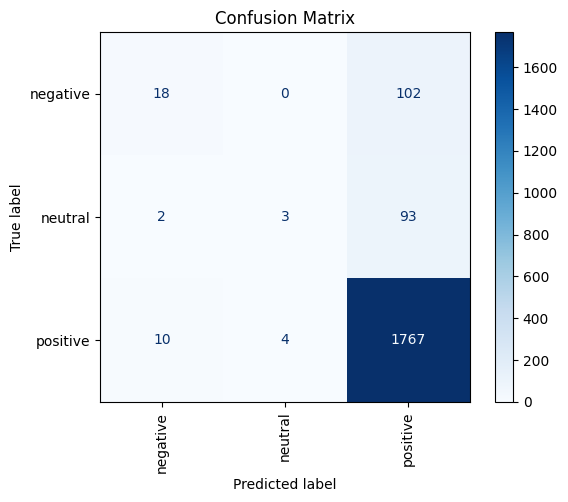

AttributeError: This 'OneVsRestClassifier' has no attribute 'predict_proba'

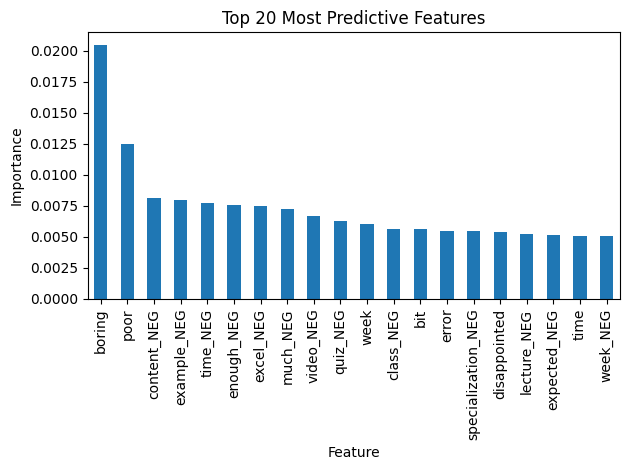

In [ ]:
# Set the best model and evaluate the models on the test data #TODO
svm_best = svm_cand_0
y_pred = svm_best.predict(x_test)
evaluate_model(rf_best, "SVM-best", x_test, y_test, svm_best.get_params(), only_metrics=False)
calculate_OvR_roc_auc_score(svm_best, x_train, y_train, x_test, y_test, senti_labels)